In [91]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## 1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.

In [92]:
# разбиваем имя файла для упрощения названия производных файлов (текстовый и сжатый)
image_basename = "clock"
image_ext = "png"
image_fullname = f"{image_basename}.{image_ext}"

image = cv2.imread(image_fullname, cv2.IMREAD_GRAYSCALE)
original_size = image.nbytes
print(f"Исходный размер: {original_size} байт")

Исходный размер: 65536 байт


In [93]:
np.savetxt(f"{image_basename}_text.txt", image, fmt='%d')

## 2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.

In [94]:
def haar_wavelet_transform(img):
    img = img.astype(np.float32)
    h, w = img.shape

    # Строки
    temp = np.zeros_like(img)
    for i in range(h):
        for j in range(w//2):
            avg = (img[i, 2*j] + img[i, 2*j+1]) / 2
            diff = (img[i, 2*j] - img[i, 2*j+1]) / 2
            temp[i, j] = avg
            temp[i, j + w//2] = diff

    # Столбцы
    result = np.zeros_like(temp)
    for j in range(w):
        for i in range(h//2):
            avg = (temp[2*i, j] + temp[2*i+1, j]) / 2
            diff = (temp[2*i, j] - temp[2*i+1, j]) / 2
            result[i, j] = avg
            result[i + h//2, j] = diff

    ll = result[0:h//2, 0:w//2]
    lh = result[0:h//2, w//2:w]
    hl = result[h//2:h, 0:w//2]
    hh = result[h//2:h, w//2:w]

    return ll, lh, hl, hh

ll, lh, hl, hh = haar_wavelet_transform(image.copy())

## 3. Выполните квантование высокочастотных компонент (прим., количество квантов = 4).

In [95]:
def quantize(channel, levels=4):
    min_val, max_val = channel.min(), channel.max()
    step = (max_val - min_val) / levels
    q = np.floor((channel - min_val) / step).astype(int)
    q = np.clip(q, 0, levels - 1)
    return q

lh_q = quantize(lh)
hl_q = quantize(hl)
hh_q = quantize(hh)

## 4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).

In [96]:
def pair_encode(component):
    flattened = component.flatten()
    pairs = []
    count = 1
    for i in range(1, len(flattened)):
        if flattened[i] == flattened[i-1]:
            count += 1
        else:
            pairs.append((flattened[i-1], count))
            count = 1
    pairs.append((flattened[-1], count))
    return pairs

with open(f"{image_basename}_compressed.txt", 'w') as f:
    f.write("LL:\n")
    np.savetxt(f, ll, fmt='%d')

    for component, name in zip([lh_q, hl_q, hh_q], ['LH', 'HL', 'HH']):
        f.write(f"\n{name}:\n")
        pairs = pair_encode(component)
        for value, count in pairs:
            f.write(f"{value} {count}\n")

## Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и изображение, полученным после преобразования Хафа и сжатием длин серий.

In [97]:
compressed_size = (ll.size * 4 +
                   sum(len(pairs)*8 for pairs in [pair_encode(lh_q),
                                                 pair_encode(hl_q),
                                                 pair_encode(hh_q)])) // 8

print(f"Размер после сжатия: {compressed_size} байт")
print(f"Коэф. сжатия: {round(original_size / compressed_size, 2)}")

Размер после сжатия: 12515 байт
Коэф. сжатия: 5.24


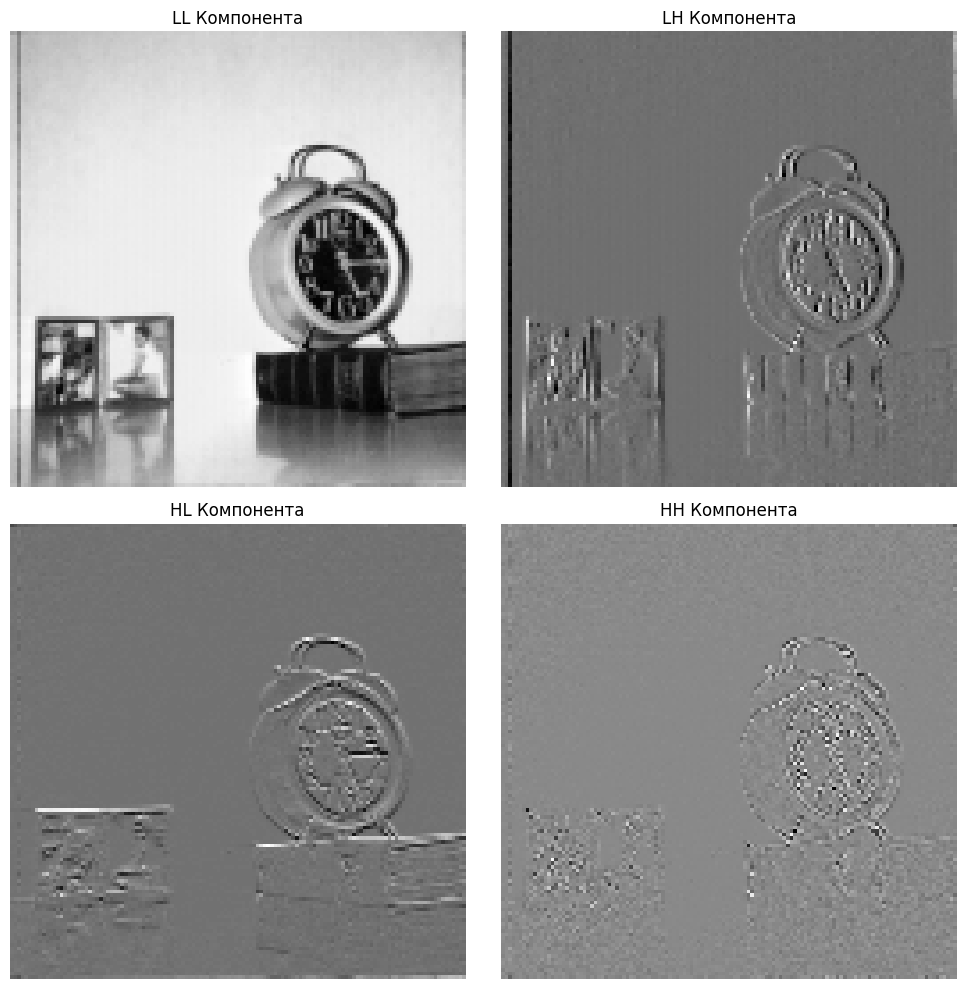

In [98]:
components = {
    "LL": ll,
    "LH": lh,
    "HL": hl,
    "HH": hh
}

plt.figure(figsize=(10, 10))

for i, (name, comp) in enumerate(components.items(), 1):
    plt.subplot(2, 2, i)
    plt.imshow(comp, cmap='gray')
    plt.title(f'{name} Компонента')
    plt.axis('off')

plt.tight_layout()
plt.show()